In [1]:
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as Poly

In [2]:
dir_location = '/scratch/ichakr2s/bdd100k/data/labels/10k/ins_seg/polygons/'
train_location = '/scratch/ichakr2s/bdd100k/data/images/10k/train/'
mosaic_location = '/scratch/ichakr2s/mosaic_aug/'


In [3]:
with open(dir_location + 'ins_seg_train.json', 'r') as f:
    bdd_data = json.load(f)

In [5]:
category_bdd10 = []
for img in bdd_data:
    for properties in img['labels']:
        if properties['category'] not in category_bdd10:
            category_bdd10.append(properties['category'])

names = "'"
for cat in category_bdd10:
  names += cat + "', '" 
names

"'car', 'person', 'truck', 'bus', 'bicycle', 'rider', 'trailer', 'motorcycle', 'caravan', 'train', '"

In [6]:
with open(mosaic_location + 'data.yaml', 'w') as f:
    f.write('train: ' + mosaic_location + 'train/images\n' + 'val: ' + mosaic_location + 'val/images\n\n' + 'nc: ' + str(len(category_bdd10)) + '\n' + 'names: [' + names[:-3] + ']')


In [7]:
def clip(minx, miny, maxx, maxy, width, height):
    if (minx > 0 and minx < width) or (maxx > 0 and maxx < width):
        if minx < 0:
            minx = 0
        if maxx > width:
            maxx = width
        if (miny > 0 and miny < height) or (maxy > 0 and maxy < height):
            if miny < 0:
                miny = 0
            if maxy > height:
                maxy = height
            return True, [minx, miny, maxx, maxy]
        else:
            return False, []
    else:
        return False, []

In [8]:
def generate_mosaic(im1_nm, im2_nm, im3_nm, im4_nm, bdd_data):

    mosaic_file_name = im1_nm[:-4] + '_' + im2_nm[:-4] + '_' + im3_nm[:-4] + '_' + im4_nm[:-4]

    x_tol = 200
    y_tol = 100

    for im in bdd_data:
        if im['name'] == im1_nm:
            lb1 = im
        if im['name'] == im2_nm:
            lb2 = im
        if im['name'] == im3_nm:
            lb3 = im
        if im['name'] == im4_nm:
            lb4 = im

    im1 = cv2.imread(train_location + lb1['name'])
    im2 = cv2.imread(train_location + lb2['name'])
    im3 = cv2.imread(train_location + lb3['name'])
    im4 = cv2.imread(train_location + lb4['name'])

    im_v1 = cv2.vconcat([im1, im2])
    im_v2 = cv2.vconcat([im3, im4])
    im_stacked = cv2.hconcat([im_v1, im_v2])

    x_cen = np.shape(im_stacked)[1] / 2
    y_cen = np.shape(im_stacked)[0] / 2
    ker_cen = [y_cen + np.random.randint(-y_tol, y_tol), x_cen + np.random.randint(-x_tol, x_tol)]

    mosaic = im_stacked[ker_cen[0]-(y_cen/2):ker_cen[0]+(y_cen/2), ker_cen[1]-(x_cen/2):ker_cen[1]+(x_cen/2)]

    cv2.imwrite(mosaic_location + 'train/images/' + mosaic_file_name + '.jpg', mosaic)

    yolostr = ''

    for an in lb1['labels']:
        vert = np.array(an['poly2d'][0]['vertices']) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
        segment = Polygon(vert)
        minx, miny, maxx, maxy = segment.bounds
        flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
        if flag:
            wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
            centr_x = ((maxx + minx)/2)/x_cen
            centr_y = ((maxy + miny)/2)/y_cen
            cat = category_bdd10.index(an['category'])
            yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'

    for an in lb2['labels']:
        vert = np.array(an['poly2d'][0]['vertices'])  + np.array([0, y_cen]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
        segment = Polygon(vert)
        minx, miny, maxx, maxy = segment.bounds
        flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
        if flag:
            wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
            centr_x = ((maxx + minx)/2)/x_cen
            centr_y = ((maxy + miny)/2)/y_cen
            cat = category_bdd10.index(an['category'])
            yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'

    for an in lb3['labels']:
        vert = np.array(an['poly2d'][0]['vertices'])  + np.array([x_cen, 0]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
        segment = Polygon(vert)
        minx, miny, maxx, maxy = segment.bounds
        flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
        if flag:
            wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
            centr_x = ((maxx + minx)/2)/x_cen
            centr_y = ((maxy + miny)/2)/y_cen
            cat = category_bdd10.index(an['category'])
            yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'

    for an in lb4['labels']:
        vert = np.array(an['poly2d'][0]['vertices'])  + np.array([x_cen, y_cen]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
        segment = Polygon(vert)
        minx, miny, maxx, maxy = segment.bounds
        flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
        if flag:
            wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
            centr_x = ((maxx + minx)/2)/x_cen
            centr_y = ((maxy + miny)/2)/y_cen
            cat = category_bdd10.index(an['category'])
            yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'

    with open(mosaic_location + 'train/labels/' + mosaic_file_name + 'txt' , 'w') as f:
        f.write(yolostr)


In [15]:
image_idx = np.random.randint(0, len(bdd_data)-1, 4)

im1_nm = bdd_data[image_idx[0]]['name']
im2_nm = bdd_data[image_idx[1]]['name']
im3_nm = bdd_data[image_idx[2]]['name']
im4_nm = bdd_data[image_idx[3]]['name']

# im1_nm = '0a0a0b1a-7c39d841.jpg'
# im2_nm = '0a0ba96d-7859aaa6.jpg'
# im3_nm = '0a0c3694-f3444902.jpg'
# im3_nm = '0a0eaeaf-9ad0c6dd.jpg'

generate_mosaic(im1_nm, im2_nm, im3_nm, im4_nm, bdd_data)

TypeError: slice indices must be integers or None or have an __index__ method

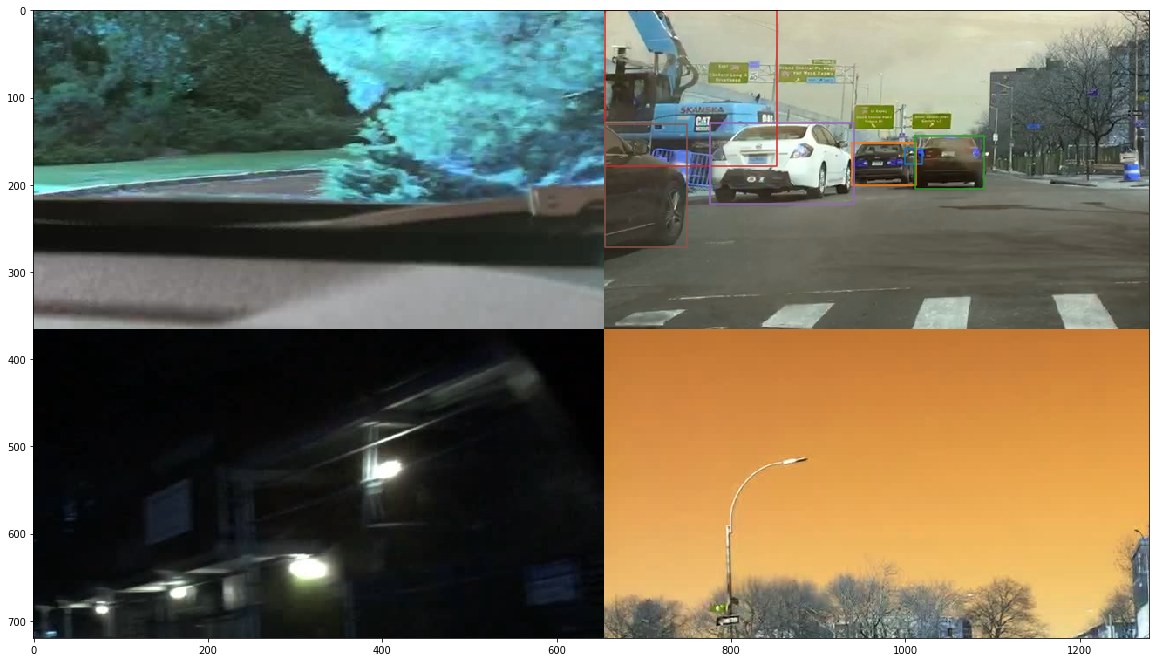

In [24]:
# image_idx = np.random.randint(0, len(bdd_data)-1, 4)

# im1_nm = bdd_data[image_idx[0]]['name']
# im2_nm = bdd_data[image_idx[1]]['name']
# im3_nm = bdd_data[image_idx[2]]['name']
# im4_nm = bdd_data[image_idx[3]]['name']

mosaic_file_name = im1_nm[:-4] + '_' + im2_nm[:-4] + '_' + im3_nm[:-4] + '_' + im4_nm[:-4]

x_tol = 200
y_tol = 100

for im in bdd_data:
    if im['name'] == im1_nm:
        lb1 = im
    if im['name'] == im2_nm:
        lb2 = im
    if im['name'] == im3_nm:
        lb3 = im
    if im['name'] == im4_nm:
        lb4 = im
        
im1 = cv2.imread(train_location + lb1['name'])
im2 = cv2.imread(train_location + lb2['name'])
im3 = cv2.imread(train_location + lb3['name'])
im4 = cv2.imread(train_location + lb4['name'])

im_v1 = cv2.vconcat([im1, im2])
im_v2 = cv2.vconcat([im3, im4])
im_stacked = cv2.hconcat([im_v1, im_v2])

x_cen = np.shape(im_stacked)[1] / 2
y_cen = np.shape(im_stacked)[0] / 2
ker_cen = [y_cen + np.random.randint(-y_tol, y_tol), x_cen + np.random.randint(-x_tol, x_tol)]

mosaic = im_stacked[ker_cen[0]-(y_cen/2):ker_cen[0]+(y_cen/2), ker_cen[1]-(x_cen/2):ker_cen[1]+(x_cen/2)]

cv2.imwrite(mosaic_location + 'images/' + mosaic_file_name + '.jpg', mosaic)

plt.figure(figsize=(20,20))
ax = plt.subplot()
ax.clear()

yolostr = ''

for an in lb1['labels']:
    vert = np.array(an['poly2d'][0]['vertices']) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
    segment = Polygon(vert)
    minx, miny, maxx, maxy = segment.bounds
    flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
    if flag:
        wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
        centr_x = ((maxx + minx)/2)/x_cen
        centr_y = ((maxy + miny)/2)/y_cen
        cat = category_bdd10.index(an['category'])
        yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'
        plt.plot([i_bds[0], i_bds[0], i_bds[2], i_bds[2], i_bds[0]], [i_bds[1], i_bds[3], i_bds[3], i_bds[1], i_bds[1]])
    
for an in lb2['labels']:
    vert = np.array(an['poly2d'][0]['vertices'])  + np.array([0, y_cen]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
    segment = Polygon(vert)
    minx, miny, maxx, maxy = segment.bounds
    flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
    if flag:
        wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
        centr_x = ((maxx + minx)/2)/x_cen
        centr_y = ((maxy + miny)/2)/y_cen
        cat = category_bdd10.index(an['category'])
        yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'
        plt.plot([i_bds[0], i_bds[0], i_bds[2], i_bds[2], i_bds[0]], [i_bds[1], i_bds[3], i_bds[3], i_bds[1], i_bds[1]])

for an in lb3['labels']:
    vert = np.array(an['poly2d'][0]['vertices'])  + np.array([x_cen, 0]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
    segment = Polygon(vert)
    minx, miny, maxx, maxy = segment.bounds
    flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
    if flag:
        wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
        centr_x = ((maxx + minx)/2)/x_cen
        centr_y = ((maxy + miny)/2)/y_cen
        cat = category_bdd10.index(an['category'])
        yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'
        plt.plot([i_bds[0], i_bds[0], i_bds[2], i_bds[2], i_bds[0]], [i_bds[1], i_bds[3], i_bds[3], i_bds[1], i_bds[1]])

for an in lb4['labels']:
    vert = np.array(an['poly2d'][0]['vertices'])  + np.array([x_cen, y_cen]) - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2])
    segment = Polygon(vert)
    minx, miny, maxx, maxy = segment.bounds
    flag, i_bds = clip(minx, miny, maxx, maxy, x_cen, y_cen)
    if flag:
        wth, hgt = (maxx - minx)/x_cen, (maxy - miny)/y_cen
        centr_x = ((maxx + minx)/2)/x_cen
        centr_y = ((maxy + miny)/2)/y_cen
        cat = category_bdd10.index(an['category'])
        yolostr += str(cat) + ' ' + str(centr_x) + ' ' + str(centr_y) + ' ' + str(wth) + ' ' + str(hgt)  + '\n'
        plt.plot([i_bds[0], i_bds[0], i_bds[2], i_bds[2], i_bds[0]], [i_bds[1], i_bds[3], i_bds[3], i_bds[1], i_bds[1]])

with open(mosaic_location + 'labels/' + mosaic_file_name + 'txt' , 'w') as f:
    f.write(yolostr)

plt.imshow(mosaic)

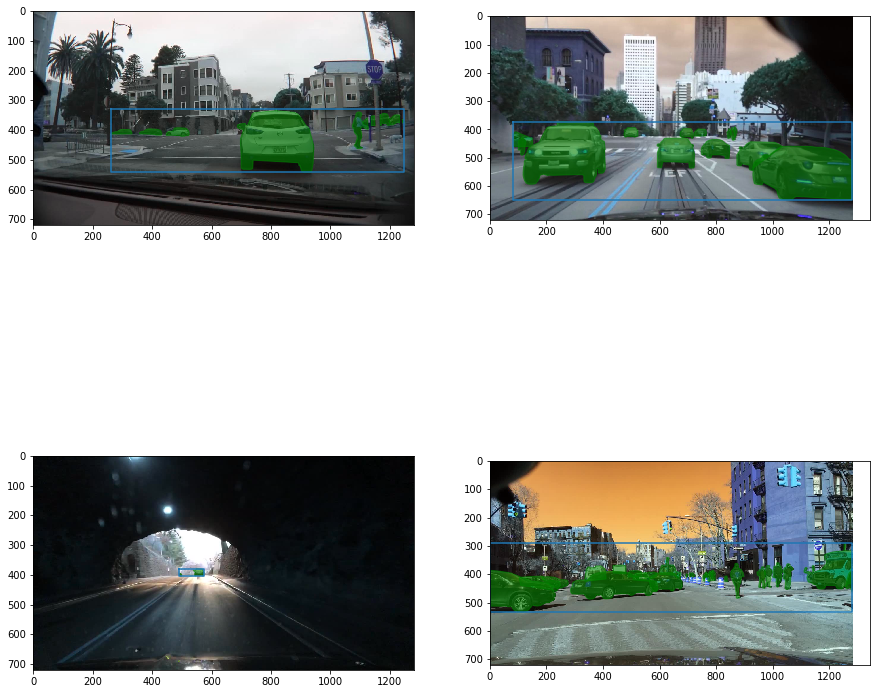

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

img1 = bdd_data[0]
im1 = cv2.imread(train_location + img1['name'])
axs[0, 0].imshow(im1)
im1_minx = float('inf')
im1_miny = float('inf')
im1_maxx = -float('inf')
im1_maxy = -float('inf')
for idx, an in enumerate(img1['labels']):
    seg = np.array(an['poly2d'][0]['vertices'])
    segment = Polygon(seg)
    im_bounds = segment.bounds
    if im1_minx > im_bounds[0]:
        im1_minx = im_bounds[0]
    if im1_miny > im_bounds[1]:
        im1_miny = im_bounds[1]
    if im1_maxx < im_bounds[2]:
        im1_maxx = im_bounds[2]
    if im1_maxy < im_bounds[3]:
        im1_maxy = im_bounds[3]
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    axs[0,0].add_patch(f)
axs[0,0].plot([im1_minx, im1_minx, im1_maxx, im1_maxx, im1_minx], [im1_miny, im1_maxy, im1_maxy, im1_miny, im1_miny])
    
img2 = bdd_data[1]
im2 = cv2.imread(train_location + img2['name'])
axs[0, 1].imshow(im2)
im2_minx = float('inf')
im2_miny = float('inf')
im2_maxx = -float('inf')
im2_maxy = -float('inf')
for idx, an in enumerate(img2['labels']):
    seg = np.array(an['poly2d'][0]['vertices'])
    segment = Polygon(seg)
    im_bounds = segment.bounds
    if im2_minx > im_bounds[0]:
        im2_minx = im_bounds[0]
    if im2_miny > im_bounds[1]:
        im2_miny = im_bounds[1]
    if im2_maxx < im_bounds[2]:
        im2_maxx = im_bounds[2]
    if im2_maxy < im_bounds[3]:
        im2_maxy = im_bounds[3]
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    axs[0,1].add_patch(f)
axs[0,1].plot([im2_minx, im2_minx, im2_maxx, im2_maxx, im2_minx], [im2_miny, im2_maxy, im2_maxy, im2_miny, im2_miny])

img3 = bdd_data[2]
im3 = cv2.imread(train_location + img3['name'])
axs[1, 0].imshow(im3)
im3_minx = float('inf')
im3_miny = float('inf')
im3_maxx = -float('inf')
im3_maxy = -float('inf')
for idx, an in enumerate(img3['labels']):
    seg = np.array(an['poly2d'][0]['vertices'])
    segment = Polygon(seg)
    im_bounds = segment.bounds
    if im3_minx > im_bounds[0]:
        im3_minx = im_bounds[0]
    if im3_miny > im_bounds[1]:
        im3_miny = im_bounds[1]
    if im3_maxx < im_bounds[2]:
        im3_maxx = im_bounds[2]
    if im3_maxy < im_bounds[3]:
        im3_maxy = im_bounds[3]
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    axs[1,0].add_patch(f)
axs[1,0].plot([im3_minx, im3_minx, im3_maxx, im3_maxx, im3_minx], [im3_miny, im3_maxy, im3_maxy, im3_miny, im3_miny])

img4 = bdd_data[3]
im4 = cv2.imread(train_location + img4['name'])
axs[1, 1].imshow(im4)
im4_minx = float('inf')
im4_miny = float('inf')
im4_maxx = -float('inf')
im4_maxy = -float('inf')
for idx, an in enumerate(img4['labels']):
    seg = np.array(an['poly2d'][0]['vertices'])
    segment = Polygon(seg)
    im_bounds = segment.bounds
    if im4_minx > im_bounds[0]:
        im4_minx = im_bounds[0]
    if im4_miny > im_bounds[1]:
        im4_miny = im_bounds[1]
    if im4_maxx < im_bounds[2]:
        im4_maxx = im_bounds[2]
    if im4_maxy < im_bounds[3]:
        im4_maxy = im_bounds[3]
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    axs[1,1].add_patch(f)
axs[1,1].plot([im4_minx, im4_minx, im4_maxx, im4_maxx, im4_minx], [im4_miny, im4_maxy, im4_maxy, im4_miny, im4_miny])


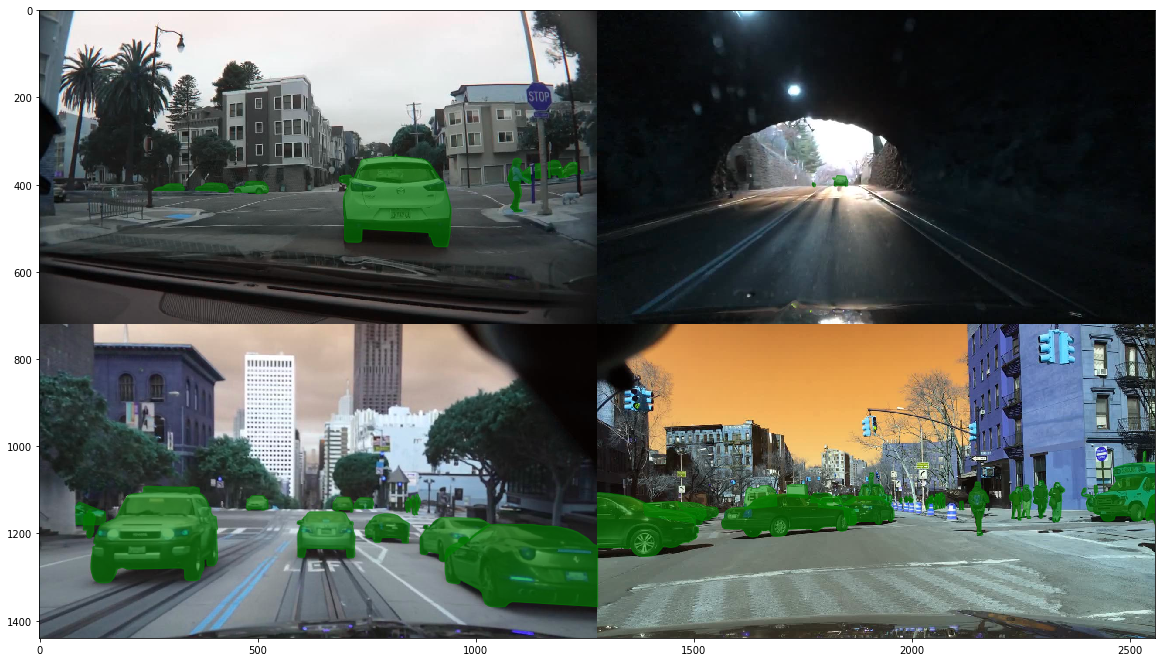

In [46]:
plt.figure(figsize=(20,20))
ax = plt.subplot()
ax.clear()
instances = []

im_v1 = cv2.vconcat([im1, im2])
im1_inst = []
for idx, an in enumerate(img1['labels']):
    seg = np.array(an['poly2d'][0]['vertices'])
    im1_inst.append(seg)
    segment = Polygon(seg)
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    ax.add_patch(f)
instances.append(im1_inst)
im2_inst = []
for idx, an in enumerate(img2['labels']):
    seg = np.array(an['poly2d'][0]['vertices']) + np.array([0, 720])
    im2_inst.append(seg)
    segment = Polygon(seg)
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    ax.add_patch(f)
instances.append(im2_inst)
im_v2 = cv2.vconcat([im3, im4])
im3_inst = []
for idx, an in enumerate(img3['labels']):
    seg = np.array(an['poly2d'][0]['vertices']) + np.array([1280, 0])
    im3_inst.append(seg)
    segment = Polygon(seg)
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    ax.add_patch(f)
instances.append(im3_inst)
im4_inst = []
for idx, an in enumerate(img4['labels']):
    seg = np.array(an['poly2d'][0]['vertices']) + np.array([1280, 720])
    im4_inst.append(seg)
    segment = Polygon(seg)
    f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
    ax.add_patch(f)
instances.append(im4_inst)
im_h = cv2.hconcat([im_v1, im_v2])
plt.imshow(im_h)

instances = np.array(instances)

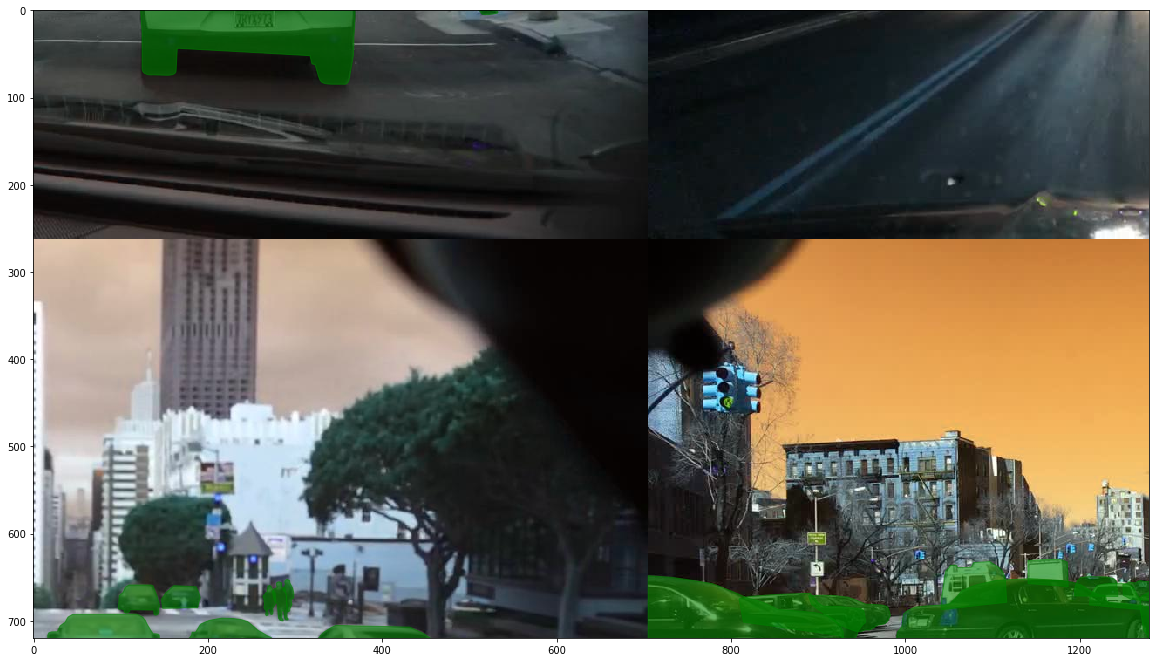

In [71]:
x_tol = 200
y_tol = 100
x_cen = np.shape(im_h)[1] / 2
y_cen = np.shape(im_h)[0] / 2

ker_cen = [y_cen + np.random.randint(-y_tol, y_tol), x_cen + np.random.randint(-x_tol, x_tol)]

mosaic = im_h[ker_cen[0]-(y_cen/2):ker_cen[0]+(y_cen/2), ker_cen[1]-(x_cen/2):ker_cen[1]+(x_cen/2)]

plt.figure(figsize=(20,20))
ax = plt.subplot()
ax.clear()

for image_inst in instances:
    for inst in image_inst:
        segment = Polygon(inst - np.array([ker_cen[1]-x_cen/2, ker_cen[0]-y_cen/2]))
        f = Poly(np.array(segment.exterior.xy).T, edgecolor = 'g', facecolor = 'g', alpha=0.6)
        ax.add_patch(f)

plt.imshow(mosaic)